In [20]:
from __future__ import print_function, division
from random import randint 
from itertools import chain
%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot

from matplotlib import rc
rc('animation', html='html5')

## Percolation

In [21]:
class RDViewer(Cell2DViewer):
    """Generates images and animations."""
    
    cmapv = plt.get_cmap('Greys')
    cmapu = plt.get_cmap('Blues')
    
    options = dict(alpha=.5,
                   interpolation='none', 
                   vmin=0, vmax=5)


    def __init__(self, viewee):
        """Initializes the attributes.
        
        viewee: the object to be represented
        """
        self.viewee = viewee
        self.imu = None
        self.imv = None
        self.hlines = None
        self.vlines = None

    def draw(self, grid=False):
        """Draws the cells."""
        au = self.viewee.array.copy()
        av = self.viewee.array2.copy()
        
        n, m = av.shape
        plt.axis([0, m, 0, n])
        plt.xticks([])
        plt.yticks([])

        self.options['extent'] = [0, m, 0, n]
        self.imu = plt.imshow(au, cmap=self.cmapu, **self.options)
        self.imv = plt.imshow(av, cmap=self.cmapv, **self.options)

    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step(iters=1)

        self.imu.set_array(self.viewee.array)
        self.imv.set_array(self.viewee.array2)
        return (self.imu, self.imv)

In [22]:
from Cell2D import Cell2D, Cell2DViewer
from scipy.signal import correlate2d
class Percolation(Cell2D):
    """Percolation Cellular Automaton."""

    kernel = np.array([[0, 1, 0],
                       [1, -4, 1],
                       [0, 1, 0]])

    options = dict(mode='same', boundary='wrap')
    def __init__(self, n, m=None, p=0.5, r=0.1, seed = 22):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        p: probability of porousness
        r: diffusion rate constant
        """
        self.r = r
        self.p = p
        m = n if m is None else m
        if seed is not None:
            np.random.seed(seed)
        # fill random areas with inpermiable materials
        self.array2 = np.random.choice([0.0,5.0], (n, m), p=[1-p, p])
        # fill remaining areas with permiable materials/caverns
        self.array = np.zeros((n, m), np.float)
        self.array = np.random.choice([0.0,5.0], (n, m), p=[1-(p/100), (p/100)])
        # fill center with gas cells
        #self.array[n/2, m/2] = 5
    def step(self):
        """Executes one time step."""
        a = self.array
        a2 = self.array2
        c = correlate2d(a, self.kernel, mode='same', boundary='fill')
        c2 = correlate2d(a2, self.kernel, mode='same', boundary= 'fill')
        #self.array +=  self.r * c
        
        #self.array -=  self.r * c
        #if (np.any((a>=0) & (c>=1) & (a2==0) & (c2==5))):
        self.array[((a==0) & (c>=5)) & (a2==0)] =  5
        self.array +=  self.r * c
        #else:
            #self.array2[(a2==5) & (c2==5)] = 5
            #self.array -=  self.r * c
    def num_wet(self, cols=None):
        """Total number of wet cells.
        
        cols: number of columns to select
        """
        a = self.array[:, :cols]
        return np.sum(a == 1)
    
    def num_porous(self, cols=None):
        """Total number of porous cells."""
        a = self.array2[:, :cols]
        return np.sum(a == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
    def left_row_wet(self):
        """Number of wet cells in the left row."""
        return np.sum(self.array[0,1] == 5)
    def right_row_wet(self):
        """Number of wet cells in the top row."""
        return np.sum(self.array[0,-1] == 5)
    def top_row_wet(self):
        """Number of wet cells in the top row."""
        return np.sum(self.array[1] == 5)
  
  

In [23]:
def test_perc(perc):
    """Run a percolation model.
    
    Runs until water gets to the bottom row or nothing changes.
    
    returns: (boolean, number of steps)
    """
    num_wet = perc.num_wet()

    num_steps = 0
    while True:
        perc.step()
        num_steps += 1

        if perc.bottom_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        
        if perc.left_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        
        if perc.right_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps
        if perc.top_row_wet():
            return True, num_steps
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False, num_steps

        num_wet = new_num_wet

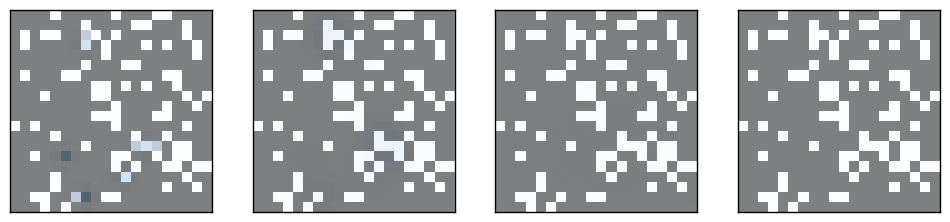

In [25]:
seed = 22
perc = Percolation(20, p=0.8)
viewer = RDViewer(perc)

thinkplot.preplot(cols=4)
viewer.step()
viewer.draw()

thinkplot.subplot(2)
viewer.step(10)
viewer.draw()

thinkplot.subplot(3)
viewer.step(100)
viewer.draw()

thinkplot.subplot(4)
viewer.step(1000)
viewer.draw()

In [26]:
perc = Percolation(50, p=0.5)
flag, num_steps = test_perc(perc)
print(flag, num_steps)

False 1


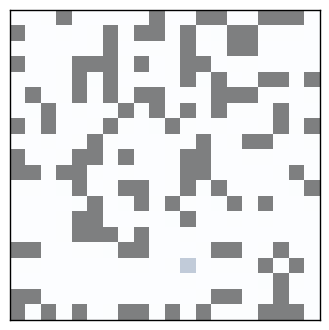

In [27]:
perc = Percolation(20, p=0.3)
viewer = RDViewer(perc)
anim = viewer.animate(frames=500)

In [28]:
anim

In [145]:
# from scipy.signal import correlate2d
# from matplotlib import animation

# class Percolation3D(Percolation):
    
#     kernel = np.array([[0, 1, 0],
#                    [1, 0, 1],
#                    [0, 1, 0]])
    
#     layers = []
    
    
#     def __init__(self, n, m=None, z=None, p=0.5, seed=None):
#         """Initializes the attributes.

#         n: number of rows
#         m: number of columns
#         z: number of layers
#         p: probability of porousness
#         """
#         self.p = p
#         m = n if m is None else m
#         z = n if z is None else z
#         if seed is not None:
#             np.random.seed(seed)
        
#         # create array of 2D porous layers which make up the 3D porous space
#         self.layers = [np.random.choice([0, 1], (n, m), p=[1-p, p]) for x in range(z)]
        
#         # fill the center with wet cells
#         self.layers[z//2][n//2,m//2] = 5
        
#     def step(self):
#         """Executes one time step."""

#         num_layers = len(self.layers)
        
#         for l in range(num_layers):
#             a = self.layers[l]
#             # expand to porous cells
#             c = correlate2d(a, self.kernel, mode='same')
#             self.layers[l][(a==1) & (c>=5)] = 5
    
#         for l in range(num_layers):
            
#             adj_wet_cells = np.zeros((len(self.layers[0][0]),len(self.layers[0])),dtype=np.int);
            
#             left = l-1
#             right = l+1
            
#             if left >= 0:
#                 adj_wet_cells[self.layers[left]>=5] = 5
                
#             if right < num_layers:
#                 adj_wet_cells[self.layers[right]>=5] = 5

#             a = self.layers[l]

#             # fill the porous cells of the current layer
#             # if the adjacent cells are wet
#             self.layers[l][(a==1) & (adj_wet_cells>=5)]=5
        
 
            
#     def show_layers(self):
#         for x in range(len(self.layers)):
#             print(self.layers[x]) 
    
#     def get_layer(self, layer_index):
#         return self.layers[layer_index]
    
#     def draw(self):
#         Percolation.draw(self)

            
            

class PercolationViewer3D(Cell2DViewer):
    """Draws and animates a 3D Percolation object."""
    cmap = plt.get_cmap('Blues')
    options = dict(alpha=0.6,
                   interpolation='none', 
                   vmin=0, vmax=5)
    
    view_layers = []
    
    def __init__(self, perc3d):
        Cell2DViewer.__init__(self, perc3d)
        self.perc = perc3d
            
    
    def draw(self):
        z = len(self.perc.layers)
        thinkplot.preplot(cols=z)
        for x in range(z):
            thinkplot.subplot(x+1)
            self.perc.array = self.perc.layers[x]
            Cell2DViewer.draw(self)

    def animate(self, frames=20, interval=200, grid=False):
        """Creates an animation.

        frames: number of frames to draw
        interval: time between frames in ms
        """
        fig = plt.figure()
        self.draw()
        anim = animation.FuncAnimation(fig, self.animate_func,
                                       init_func=self.init_func,
                                       frames=frames, interval=interval)
        return anim

    def init_func(self):
        """Called at the beginning of an animation."""
        pass
    
    def animate_func(self,i):
        if i > 0:
            self.step()
            self.draw()
        

In [234]:
from scipy.signal import correlate2d
from matplotlib import animation

class Percolation3D(Percolation):
    
    kernel = np.array([[0, 1, 0],
                   [1, 0, 1],
                   [0, 1, 0]])
    kernel2 = np.array([[0, 1, 0],
                   [1, -4, 1],
                   [0, 1, 0]])
    
    layers = []
    
    
    def __init__(self, n, m=None, z=None, p=0.5, r=0.1, seed=None):
        """Initializes the attributes.

        n: number of rows
        m: number of columns
        z: number of layers
        p: probability of porousness
        """
        self.p = p
        self.r = r
        self.cnt = 0
        m = n if m is None else m
        z = n if z is None else z
        if seed is not None:
            np.random.seed(seed)
        
        # create array of 2D porous layers which make up the 3D porous space
        self.layers = [np.random.choice([0.0, 1.0], (n, m), p=[1-p, p]) for x in range(z)]
        
        # fill the center with wet cells
        #self.layers[z//2][n//2,m//2] = 5
        
        #fill center cell of top layer
        self.layers[0][n//2,m//2] = 5
        
#         self.layers2 = [np.random.choice([0.0,5.0], (n, m), p=[1-p, p]) for x in range(z)]
        #gas
#         self.layers = [np.random.choice([0.0,5.0], (n, m), p=[1-(p/100), (p/100)]) for y in range(z)]
        # fill random areas with inpermiable materials
#         self.array2 = np.random.choice([0.0,5.0], (n, m), p=[1-p, p])
#         # fill remaining areas with permiable materials/caverns
#         self.array = np.random.choice([0.0,5.0], (n, m), p=[1-(p/100), (p/100)])
        
    def step(self):
        """Executes one time step."""
        

        num_layers = len(self.layers)
        
#         a = self.array
#         a2 = self.array2
#         c = correlate2d(a, self.kernel, mode='same', boundary='fill')
#         c2 = correlate2d(a2, self.kernel, mode='same', boundary= 'fill')
        
#         self.array[((a==0) & (c>=5)) & (a2==0)] =  5
#         self.array +=  self.r * c

#         for l in range(num_layers):
#             a = self.layers[l]
#             a2 = self.layers2[l]
#             c = correlate2d(a, self.kernel, mode='same', boundary='fill')
#             c2 = correlate2d(a2, self.kernel, mode='same', boundary= 'fill')   
#             self.layers[l][(a==0) & (c>=5) & (a2==0)] = 5
#             self.layers[l] += self.r*c
        
        #
        blk_diff = 5-self.r*self.cnt if 5-self.r*self.cnt > 1 else 1.1
    
        for l in range(num_layers):
            a = self.layers[l]
            # expand to porous cells
            c = correlate2d(a, self.kernel, mode='same')
            self.layers[l][(a==1) & (c>4)] = blk_diff
            
    
        # for each layer set the porous cells wet
        # if cells of the adjacent layers are wet
        for l in range(num_layers):
            
            adj_wet_cells = np.zeros((len(self.layers[0][0]),len(self.layers[0])),dtype=np.float);
            
            left = l-1
            right = l+1
            
            if left >= 0:
#                 adj_wet_cells[self.layers[left]>=5] = 5
                adj_wet_cells[self.layers[left] > 1] = blk_diff
                
            if right < num_layers:
#                 adj_wet_cells[self.layers[right]>=5] = 5
                adj_wet_cells[self.layers[right] > 1] = blk_diff
    
            a = self.layers[l]

            # fill the porous cells of the current layer
            # if the adjacent cells are wet
            self.layers[l][(a==1) & (adj_wet_cells> 1)]= blk_diff
            
        self.cnt += 1
        
 
            
    def show_layers(self):
        for x in range(len(self.layers)):
            print(self.layers[x]) 
    
    def get_layer(self, layer_index):
        return self.layers[layer_index]
    
    def draw(self):
        Percolation.draw(self)

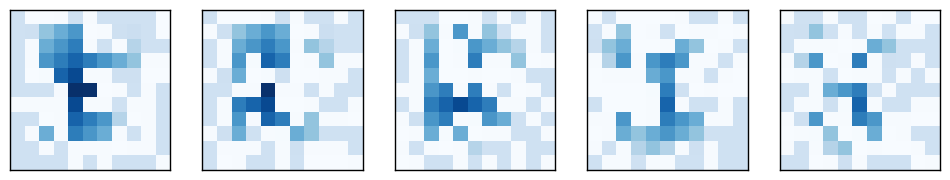

In [236]:
seed = 10

perc3d = Percolation3D(11,z=5,r=0.5,p=0.5)

viewer = PercolationViewer3D(perc3d)
anim = viewer.animate(frames=50)
anim

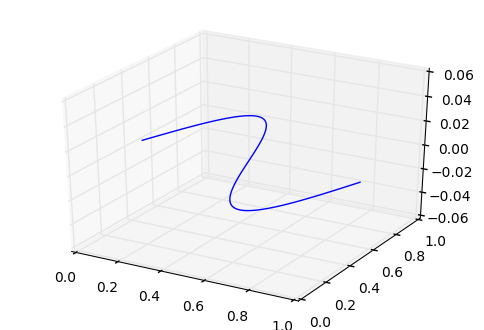

In [229]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = np.linspace(0, 1, 100)
y = np.sin(x * 2 * np.pi) / 2 + 0.5
ax.plot(x, y, zs=0, zdir='z', label='curve in (x,y)')